In [1]:
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import pandas as pd 
import seaborn as sns
from tqdm.notebook import tqdm

import ipywidgets
from ipywidgets import interact
import IPython
# If in your browser the figures are not nicely vizualized, change the following line. 
rcParams['font.size'] = 12

import warnings
warnings.filterwarnings('ignore')

import pyro.optim 
from pyro.infer import Predictive, SVI, Trace_ELBO, HMC, MCMC, NUTS, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.autoguide import AutoDelta, AutoDiagonalNormal
import pyro.distributions as dist

import torch 
from torch import nn
from torch.distributions import MultivariateNormal, constraints


prior_c, svi_c, mcmc_c = sns.color_palette()[:3]



# Bayesian Regression with Pyro

We try to learn a model $y \sim \mathcal{N}(b + w x, \sigma^2)$

In [2]:
def model(x, y=None):
    b = pyro.sample("b", dist.Normal(0., 10.))      # Bias Coefficient
    w = pyro.sample("w", dist.Normal(0., 1.))       # Linear Coefficient
    sigma = pyro.sample("sigma", dist.Uniform(0, 10.)) 
    mean = b + w * x
    with pyro.plate("data", len(x)):
#         pyro.sample("obs", dist.Uniform(mean - sigma, mean + sigma), obs=y)
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

        
def guide(x, y): # custom guide
    # Define parameters.
    b_loc = pyro.param('b_loc', torch.tensor(0.))
    b_scale = pyro.param('b_scale', torch.tensor(1.), constraint=constraints.positive)
    
    w_loc = pyro.param('weights_loc',  torch.randn(1))
    w_scale = pyro.param('weights_scale', torch.ones(1), constraint=constraints.positive)

    sigma_loc = pyro.param('sigma_loc', torch.tensor(.5), constraint=constraints.positive)

    # Generate samples
    b = pyro.sample("b", dist.Normal(b_loc, b_scale))
    w = pyro.sample("w", dist.Normal(w_loc, w_scale))
#     sigma = pyro.sample("sigma", dist.Uniform(0, sigma_loc))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = b + w * x 
    
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

## Generate Data and plot the Prior

Site: b
       mean       std         5%       25%       50%       75%        95%
0 -1.906682  9.569304 -16.676992 -8.922837 -3.104979  5.398095  12.355666 

Site: w
       mean       std        5%       25%       50%       75%       95%
0 -0.113972  0.987119 -1.493198 -0.734147 -0.138895  0.433514  1.543702 

Site: sigma
       mean       std       5%       25%       50%      75%       95%
0  5.110205  2.895673  0.56068  2.504205  5.666525  7.28003  9.649944 



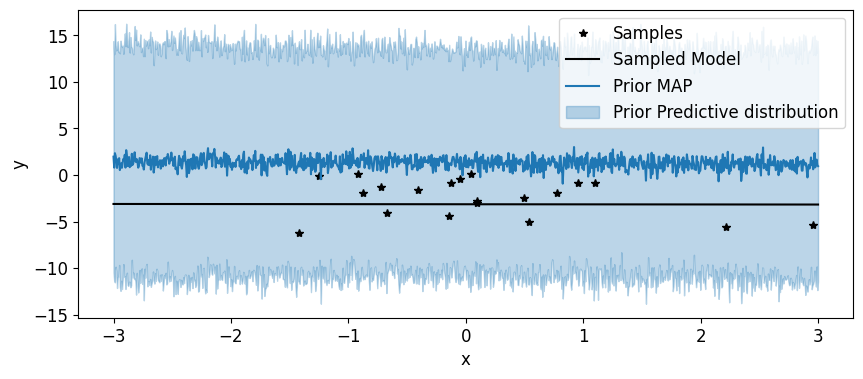

In [3]:
num_points = 20
num_samples = 1000
x = torch.randn(num_points)
test_x = torch.linspace(-3, 3, 1000)

b = dist.Normal(0, 10.).sample()
w = dist.Normal(0., 1.).sample()
sigma = dist.Uniform(0, 10.).sample()
mean = b + x * w 
y = dist.Uniform(mean - sigma, mean + sigma).sample()

# Prior samples
num_samples = 100
prior_predictive = Predictive(model, {}, num_samples=num_samples)
prior_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
                 for k, v in prior_predictive(x).items()
                 if k != "obs"}

# Prior samples
for name, values in summary(prior_samples).items():
    print("Site: {}".format(name))
    print(values, "\n")
    

prior_predictive_model = prior_predictive(test_x)["obs"].detach().cpu().numpy()
mean = prior_predictive_model.mean(0)
std = prior_predictive_model.std(0)

with torch.no_grad():
    plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
    plt.plot(x, y, 'k*', label='Samples')
    plt.plot(test_x, b + test_x * w, 'k-', label='Sampled Model')
    plt.plot(test_x, mean, 'b-', color=prior_c, label='Prior MAP')
    plt.fill_between(test_x, mean - std, mean + std, alpha = 0.3, color=prior_c, label='Prior Predictive distribution')
    
    plt.legend(loc='best')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show();
    


## Demo Guide:

#### some explanation
To understand the above graph you need to figure out following:
- Samples: Sample from the real model points
- Sampled Model: The real model line (except for sigma)
- Prior MAP: The predictive distribution. More detail in [Predictive](https://docs.pyro.ai/en/stable/inference_algos.html#module-pyro.infer.predictive)


## Stochastic Variational Inference

  0%|          | 0/3000 [00:00<?, ?it/s]

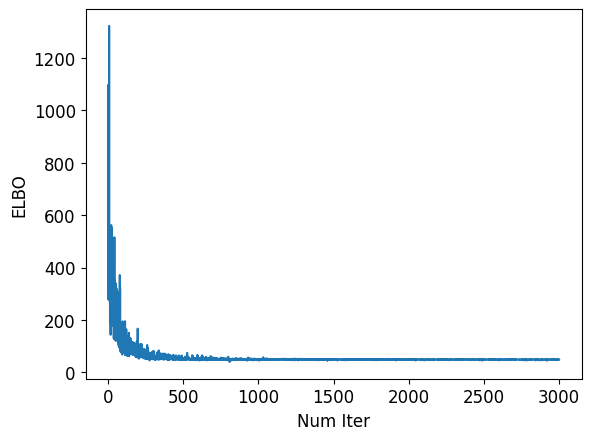

Site: b
       mean       std        5%       25%       50%       75%       95%
0 -2.375908  0.433609 -3.105254 -2.643117 -2.375295 -2.059348 -1.729628 

Site: w
       mean      std        5%       25%       50%       75%       95%
0 -0.555278  0.41617 -1.239967 -0.829337 -0.563697 -0.274987  0.225798 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  1.979262  0.051215  1.893667  1.947213  1.981005  2.011555  2.065948 



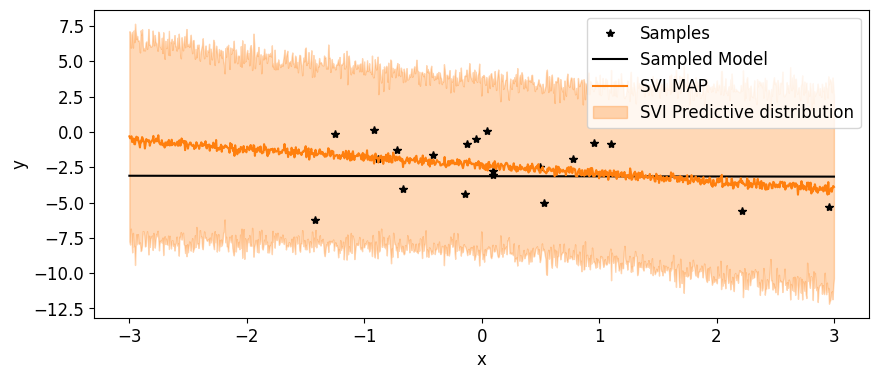

In [4]:
svi = SVI(model,
          guide,
          pyro.optim.Adam({"lr": 1e-2}),
          loss=Trace_ELBO())
pyro.clear_param_store()
num_iters = 3000
elbo = []
for i in tqdm(range(num_iters)):
    elbo.append(svi.step(x, y))

plt.plot(elbo)

plt.xlabel('Num Iter')
plt.ylabel('ELBO')
plt.show()


svi_predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in svi_predictive(x, y).items()
               if k != "obs"}

for name, values in summary(svi_samples).items():
    print("Site: {}".format(name))
    print(values, "\n")

svi_predictive_model = svi_predictive(test_x, torch.randn(1000))["obs"].detach().cpu().numpy()
mean = svi_predictive_model.mean(0)
std = svi_predictive_model.std(0)

svi_predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_predictive_model = svi_predictive.get_samples(test_x, None)["obs"]

with torch.no_grad():
    mean = svi_predictive_model.mean(0)
    std = svi_predictive_model.std(0)
    plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
    plt.plot(x, y, 'k*', label='Samples')
    plt.plot(test_x, b + test_x * w, 'k-', label='Sampled Model')
    plt.plot(test_x, mean, color=svi_c, label='SVI MAP')
    plt.fill_between(test_x, mean - 3 * std, mean + 3 * std, alpha = 0.3, color=svi_c, label='SVI Predictive distribution')
    
    plt.legend(loc='best')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show();

## Demo Guide:

#### some explanation
To understand the above stochastic variational inference
- Samples: Sample from the real model points
- Sampled Model: The real model line (except for sigma)
- Prior MAP: The predictive distribution. More detail in [Predictive](https://docs.pyro.ai/en/stable/inference_algos.html#module-pyro.infer.predictive)


## Markov Chain Monte Carlo (Hamiltonian MC)

Sample: 100%|█| 1200/1200 [00:07, 159.85it/s, step size=6.45e-01, acc. prob=0.92


Site: b
    mean       std        5%       25%      50%       75%       95%
0 -2.322  0.474427 -3.085247 -2.628268 -2.34674 -2.031724 -1.513899 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  2.118001  0.374067  1.598331  1.865266  2.072009  2.329182  2.854542 

Site: w
       mean       std        5%       25%       50%       75%       95%
0 -0.490563  0.409472 -1.121637 -0.785016 -0.499407 -0.216143  0.173778 



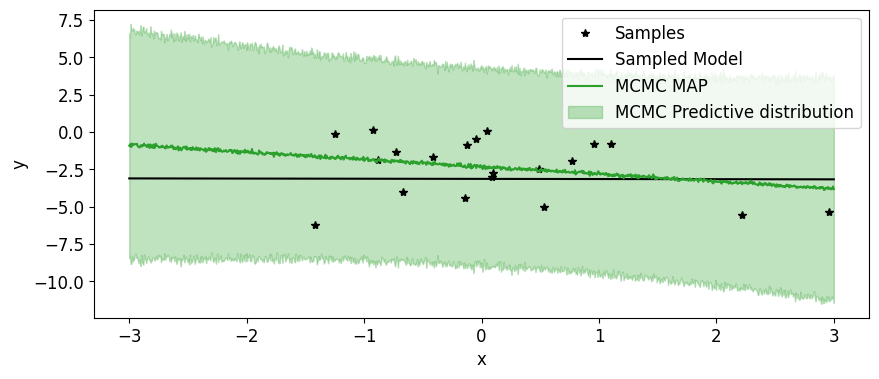

In [5]:
kernel = NUTS(model)  # HMC
# kernel = HMC(model, step_size=0.0855, num_steps=4)

mcmc = MCMC(kernel, num_samples=1000, warmup_steps=200)
mcmc.run(x, y)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

for name, values in summary(hmc_samples).items():
    print("Site: {}".format(name))
    print(values, "\n")
    
    
mcmc_predictive_samples = Predictive(model, posterior_samples=mcmc.get_samples())(test_x, None)["obs"]

with torch.no_grad():
    mean = mcmc_predictive_samples.mean(0)
    std = mcmc_predictive_samples.std(0)
    plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
    plt.plot(x, y, 'k*', label='Samples')
    plt.plot(test_x, b + test_x * w, 'k-', label='Sampled Model')
    plt.plot(test_x, mean, color=mcmc_c, label='MCMC MAP')
    plt.fill_between(test_x, mean - 3 * std, mean + 3 * std, alpha = 0.3, color=mcmc_c, label='MCMC Predictive distribution')
    
    plt.legend(loc='best')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show();


## Demo Guide:

#### some explanation
Compared with the above Laplace approximation. This demo use train the GP with Binary likelihood (Bernoulli distribution). As you can see using the Bernoulli distribution in variational inference cost more time than laplace distribution
- num points: The number of training points which will be uniformly generate from 0 - 1
- Do 100/1000 more steps: Initialize with 200 steps training after number points change.

#### play around
- See how the prediction changes with more data points
- See how the uncertainty change in the area with more or less data.
- See how the uncertainty changes with more and more training steps

# Compare distributions

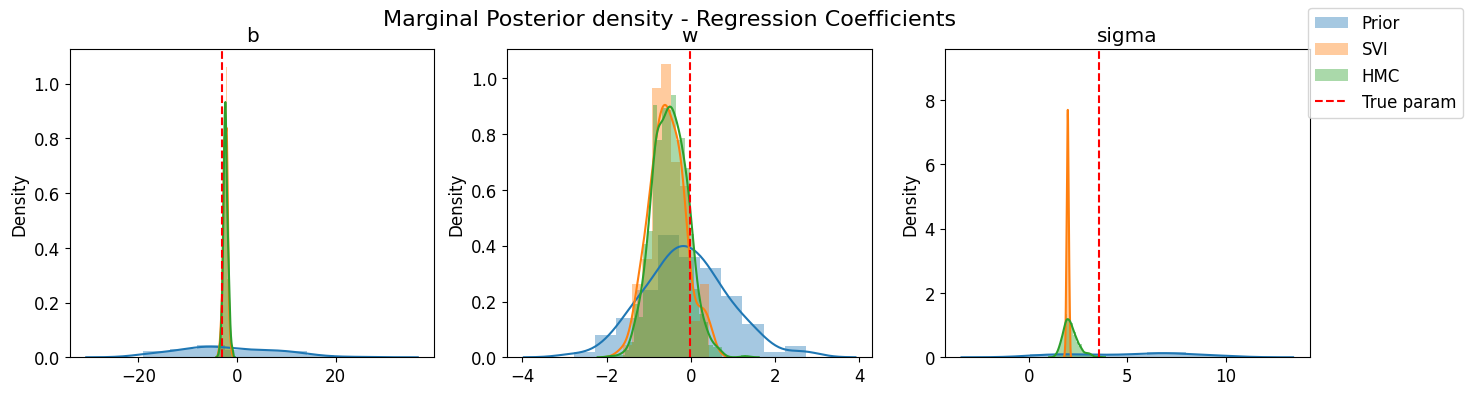

In [6]:
sites = ["b", "w", "sigma"]
values = {"b": b, "w": w, "sigma": sigma}

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(prior_samples[site], ax=ax, label="Prior", color=prior_c)
    sns.distplot(svi_samples[site], ax=ax, label="SVI", color=svi_c)
    sns.distplot(hmc_samples[site], ax=ax, label="HMC", color=mcmc_c)
    ax.axvline(x=values[site], color='r', linestyle='dashed', label='True param')
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');
